In [2]:
import pandas as pd 
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
df = pd.read_csv('../data/Locations_of_Docked_Bikeshare_Stations_by_System_and_Year.csv')

In [4]:
#change to lower case column names 
df.columns = ['the_geom', 'id', 'fac_id', 'bike_id', 'system_id', 'system_name',
       'year', 'asofdate', 'fac_name', 'address', 'city', 'state', 'zipcode',
       'cbsa_code', 'longitude', 'latitude']

In [5]:
df = df[df['year']<2020]

In [6]:
#Fix issue with address column - a portion of the dataframe has an extra column of 0s shifting everything off 
df1 = df[df['zipcode']!=0]
df2 = df[df['zipcode']==0]

In [7]:
df2.columns = ['the_geom', 'id', 'fac_id', 'bike_id', 'system_id', 'system_name',
       'year', 'asofdate', 'fac_name', 'city', 'state', 'zipcode','to_delete',
       'cbsa_code', 'longitude', 'latitude']

In [8]:
df2 = df2.drop('to_delete',axis=1)
df1 = df1.drop('address',axis=1)

In [9]:
df = pd.concat([df1,df2],axis=0)

In [10]:
#Fill NA values 
df['system_name'] = df['system_name'].fillna(value='Hubway (03/2018 re-launched as Blue Bikes)')

In [11]:
#Fix zips - make strings, add leading zeros, delete zips associated with 2 states  
df['zipcode'] = df['zipcode'].astype('str')
df['zipcode'] = ["0"+z if len(z)<5 else z for z in df['zipcode']]

temp = pd.DataFrame(df.groupby('zipcode')['state'].agg('nunique').reset_index())
zips_2_states = temp[temp['state']>1]['zipcode']
df = df[~df['zipcode'].isin(np.array(zips_2_states))]

In [12]:
df['asofdate'].unique()

array([201512, 201612, 201712, 201812, 201912])

In [13]:
#year usable - At the start of 2019, the most recent data available is 2018 (made available December of 2018)
df['bs_year_usable'] = df['year']+1
df['bs_year_usable'].unique()

array([2016, 2017, 2018, 2019, 2020])

In [14]:
df = df[df['bs_year_usable']<2020]

In [15]:
#Resulting years 
df['bs_year_usable'].unique()

array([2016, 2017, 2018, 2019])

In [16]:
#Create 2 features: 
# 1) Number of docked bike stations per zip code (bs_total_stations)
# 2) Number of bike sharing systems per zip code (bs_total_systems) -- only 40 zips have more than 1 brand 
bikes = df.groupby(['zipcode','year','asofdate','bs_year_usable'])\
          .agg({'fac_id':'nunique','system_id':'nunique'})\
          .reset_index()
bikes.columns = ['bs_zipcode', 'bs_year', 'bs_asofdate', 'bs_year_usable', 'bs_total_stations', 'bs_total_systems'] 

In [17]:
#Convert years to strings
bikes['bs_year'] = bikes['bs_year'].astype('string')
bikes['bs_asofdate'] = bikes['bs_asofdate'].astype('string')
bikes['bs_year_usable'] = bikes['bs_year_usable'].astype('string')


In [18]:
bikes['bs_zipcode'].nunique()

1489

In [19]:
zri = pd.read_csv('../data/zri_multifamily_v2.csv')
zri['zip'] = zri['zip'].astype('string')
zri['zip'] = ["0"+z if len(z)<5 else z for z in zri['zip']]
zri['year'] = pd.to_datetime(zri['year-month'],format="%Y-%m").dt.year
zri['year'] = zri['year'].astype('string')
zri['year-month'] = pd.to_datetime(zri['year-month'],format="%Y-%m")

In [20]:
zri['zip'].nunique()

1302

In [21]:
zri[['zip','year']].shape

(93744, 2)

In [22]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4662 entries, 0 to 4661
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   bs_zipcode         4662 non-null   object
 1   bs_year            4662 non-null   string
 2   bs_asofdate        4662 non-null   string
 3   bs_year_usable     4662 non-null   string
 4   bs_total_stations  4662 non-null   int64 
 5   bs_total_systems   4662 non-null   int64 
dtypes: int64(2), object(1), string(3)
memory usage: 218.7+ KB


In [23]:
zri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93744 entries, 0 to 93743
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   zip         93744 non-null  object        
 1   City        93744 non-null  object        
 2   State       93744 non-null  object        
 3   Metro       93672 non-null  object        
 4   CountyName  93744 non-null  object        
 5   year-month  93744 non-null  datetime64[ns]
 6   zri         93744 non-null  float64       
 7   year        93744 non-null  string        
dtypes: datetime64[ns](1), float64(1), object(5), string(1)
memory usage: 5.7+ MB


In [24]:
zri_bikes = pd.merge(zri,bikes,how='left',left_on=['zip','year'], right_on=['bs_zipcode','bs_year_usable'])

In [25]:
#Of the 93,744 rows of zips and years, 13,968 have information about bikes while 79776 are nulls 

In [26]:
zri_bikes.sample(4)

,zip,City,State,Metro,CountyName,year-month,zri,year,bs_zipcode,bs_year,bs_asofdate,bs_year_usable,bs_total_stations,bs_total_systems
41479,30093,Norcross,GA,Atlanta-Sandy Springs-Roswell,Gwinnett County,2014-08-01,823.0,2014,NaN,<NA>,<NA>,<NA>,NaN,NaN
29368,14210,Buffalo,NY,Buffalo-Cheektowaga-Niagara Falls,Erie County,2019-05-01,795.0,2019,14210,2018,201812,2019,1.0,1.0
12772,06770,Naugatuck,CT,New Haven-Milford,New Haven County,2016-05-01,1070.0,2016,NaN,<NA>,<NA>,<NA>,NaN,NaN
83647,92104,San Diego,CA,San Diego-Carlsbad,San Diego County,2018-08-01,1783.0,2018,92104,2017,201712,2018,5.0,1.0


In [27]:
bikes_features = zri_bikes.drop(['bs_zipcode','bs_year','bs_asofdate','bs_year_usable'],axis=1)

In [28]:
bikes_features = bikes_features.fillna(0)

In [29]:
bikes_features['has_bike_sharing'] = bikes_features['bs_total_stations']>0

In [30]:
bikes_features.head(2)

,zip,City,State,Metro,CountyName,year-month,zri,year,bs_total_stations,bs_total_systems,has_bike_sharing
0,01013,Chicopee,MA,Springfield,Hampden County,2014-01-01,928.0,2014,0.0,0.0,False
1,01013,Chicopee,MA,Springfield,Hampden County,2014-02-01,931.0,2014,0.0,0.0,False


In [31]:
#bikes_features[(bikes_features['has_bike_sharing']==True) & (bikes_features['year']=='2014')]['zip'].nunique()

In [32]:
#2014 usable (data from 2013) --> data unavailable, assume no bike sharing



#2015 usable (data from 2014) --> data unavailable, assume no bike sharing 
#2016 usable (data from 2015), there are 160 zips with bike sharing
#2017 usable (data from 2016), there are 292 zips with bike sharing
#2018 usable (data from 2017), there are 340 zips with bike sharing
#2019 usable (data from 2018), there are 372 zips with bike sharing

In [33]:
#bikes_features.to_csv('./../data/bikeshare_engineered_features.csv')

In [34]:
bikes_features[bikes_features['zip']=="07302"]

,zip,City,State,Metro,CountyName,year-month,zri,year,bs_total_stations,bs_total_systems,has_bike_sharing
14256,07302,Jersey City,NJ,New York-Newark-Jersey City,Hudson County,2014-01-01,2135.0,2014,0.0,0.0,False
14257,07302,Jersey City,NJ,New York-Newark-Jersey City,Hudson County,2014-02-01,2135.0,2014,0.0,0.0,False
14258,07302,Jersey City,NJ,New York-Newark-Jersey City,Hudson County,2014-03-01,2124.0,2014,0.0,0.0,False
14259,07302,Jersey City,NJ,New York-Newark-Jersey City,Hudson County,2014-04-01,2121.0,2014,0.0,0.0,False
14260,07302,Jersey City,NJ,New York-Newark-Jersey City,Hudson County,2014-05-01,2130.0,2014,0.0,0.0,False
14261,07302,Jersey City,NJ,New York-Newark-Jersey City,Hudson County,2014-06-01,2137.0,2014,0.0,0.0,False
14262,07302,Jersey City,NJ,New York-Newark-Jersey City,Hudson County,2014-07-01,2164.0,2014,0.0,0.0,False
14263,07302,Jersey City,NJ,New York-Newark-Jersey City,Hudson County,2014-08-01,2204.0,2014,0.0,0.0,False
14264,07302,Jersey City,NJ,New York-Newark-Jersey City,Hudson County,2014-09-01,2232.0,2014,0.0,0.0,False
14265,07302,Jersey City,NJ,New York-Newark-Jersey City,Hudson County,2014-10-01,2256.0,2014,0.0,0.0,False


In [35]:
bikes_features.groupby('zip')\
.agg({'bs_total_stations':'max'}).reset_index().sort_values(by='bs_total_stations',ascending=False).sample(35)


,zip,bs_total_stations
543,23803,0.0
1203,93906,0.0
212,10017,4.0
1026,84102,3.0
269,11010,0.0
398,13903,0.0
1288,98201,0.0
1141,91101,11.0
805,60085,0.0
779,53590,0.0


In [36]:
viz = bikes_features[bikes_features['zip']=='11101'][['year','bs_total_stations']].drop_duplicates()

In [37]:
viz['year added'] = viz['year'].astype(int)-1

In [38]:
viz

,year,bs_total_stations,year added
19512,2014,0.0,2013
19524,2015,0.0,2014
19536,2016,13.0,2015
19548,2017,13.0,2016
19560,2018,31.0,2017
19572,2019,32.0,2018


In [39]:
bikes_features[bikes_features['zip']=='95112']

,zip,City,State,Metro,CountyName,year-month,zri,year,bs_total_stations,bs_total_systems,has_bike_sharing
89424,95112,San Jose,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,2014-01-01,2023.0,2014,0.0,0.0,False
89425,95112,San Jose,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,2014-02-01,2033.5,2014,0.0,0.0,False
89426,95112,San Jose,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,2014-03-01,2044.0,2014,0.0,0.0,False
89427,95112,San Jose,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,2014-04-01,2064.0,2014,0.0,0.0,False
89428,95112,San Jose,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,2014-05-01,2051.0,2014,0.0,0.0,False
89429,95112,San Jose,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,2014-06-01,2042.0,2014,0.0,0.0,False
89430,95112,San Jose,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,2014-07-01,2051.0,2014,0.0,0.0,False
89431,95112,San Jose,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,2014-08-01,2098.0,2014,0.0,0.0,False
89432,95112,San Jose,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,2014-09-01,2157.0,2014,0.0,0.0,False
89433,95112,San Jose,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,2014-10-01,2210.0,2014,0.0,0.0,False


In [40]:

viz2 = bikes_features[bikes_features['zip']=='95112'][['year','bs_total_stations']].drop_duplicates()

In [41]:
viz2

,year,bs_total_stations
89424,2014,0.0
89436,2015,0.0
89448,2016,7.0
89460,2017,8.0
89472,2018,18.0
89484,2019,39.0


In [42]:
viz2['year added'] = viz2['year'].astype(int)-1

In [43]:
bikes_features[bikes_features['zip']=='55414']

,zip,City,State,Metro,CountyName,year-month,zri,year,bs_total_stations,bs_total_systems,has_bike_sharing
57312,55414,Minneapolis,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,2014-01-01,1368.0,2014,0.0,0.0,False
57313,55414,Minneapolis,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,2014-02-01,1368.0,2014,0.0,0.0,False
57314,55414,Minneapolis,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,2014-03-01,1333.5,2014,0.0,0.0,False
57315,55414,Minneapolis,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,2014-04-01,1299.0,2014,0.0,0.0,False
57316,55414,Minneapolis,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,2014-05-01,1285.0,2014,0.0,0.0,False
57317,55414,Minneapolis,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,2014-06-01,1264.0,2014,0.0,0.0,False
57318,55414,Minneapolis,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,2014-07-01,1250.0,2014,0.0,0.0,False
57319,55414,Minneapolis,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,2014-08-01,1246.0,2014,0.0,0.0,False
57320,55414,Minneapolis,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,2014-09-01,1256.0,2014,0.0,0.0,False
57321,55414,Minneapolis,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,2014-10-01,1271.0,2014,0.0,0.0,False


In [44]:

viz3 = bikes_features[bikes_features['zip']=='55414'][['year','bs_total_stations']].drop_duplicates()
viz3['year added'] = viz3['year'].astype(int)-1

In [45]:
viz3

,year,bs_total_stations,year added
57312,2014,0.0,2013
57324,2015,0.0,2014
57336,2016,11.0,2015
57348,2017,18.0,2016
57360,2018,18.0,2017
57372,2019,18.0,2018


In [46]:
bikes_features[bikes_features['zip']=='33145']

,zip,City,State,Metro,CountyName,year-month,zri,year,bs_total_stations,bs_total_systems,has_bike_sharing
46512,33145,Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,2014-01-01,1990.0,2014,0.0,0.0,False
46513,33145,Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,2014-02-01,1971.0,2014,0.0,0.0,False
46514,33145,Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,2014-03-01,1952.0,2014,0.0,0.0,False
46515,33145,Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,2014-04-01,1937.0,2014,0.0,0.0,False
46516,33145,Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,2014-05-01,1932.0,2014,0.0,0.0,False
46517,33145,Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,2014-06-01,1917.0,2014,0.0,0.0,False
46518,33145,Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,2014-07-01,1914.0,2014,0.0,0.0,False
46519,33145,Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,2014-08-01,1949.0,2014,0.0,0.0,False
46520,33145,Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,2014-09-01,1958.0,2014,0.0,0.0,False
46521,33145,Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,2014-10-01,1968.0,2014,0.0,0.0,False


In [47]:
df[df['zipcode']=='33145']

,the_geom,id,fac_id,bike_id,system_id,system_name,year,asofdate,fac_name,city,state,zipcode,cbsa_code,longitude,latitude,bs_year_usable
4588,POINT (-80.193948 25.76258),9498,FL3314501,633,5,Citi Bike Miami,2017,201712,SW 12th Street S Miami Ave,Miami,FL,33145,33100,-80.193948,25.76258,2018
4870,POINT (-80.193948 25.76258),4397,FL3314501,633,5,Citi Bike Miami,2016,201612,SW 12th Street S Miami Ave,Miami,FL,33145,33100,-80.193948,25.76258,2017
7692,POINT (-80.193948 25.76258),694,FL3314501,-,5,Citi Bike Miami,2015,201512,SW 12th Street S Miami Ave,Miami,FL,33145,33100,-80.193948,25.76258,2016
22620,POINT (-80.193948 25.76258),15605,FL3314501,633,5,Citi Bike Miami,2018,201812,SW 12th Street S Miami Ave,Miami,FL,33145,33100,-80.193948,25.76258,2019


In [48]:
df.groupby(['system_id','system_name']).agg({'fac_id':'count'}).reset_index().sort_values(by='fac_id',ascending=False)

,system_id,system_name,fac_id
2,3,Citi Bike,2823
54,60,Divvy,2233
50,56,Capital Bikeshare,1812
37,42,Bay Area BikeShare (became Ford GoBike 06/28/2...,841
21,25,Nice Ride Minnesota (became partially dockless...,741
0,1,Hubway (03/2018 re-launched as Blue Bikes),715
30,34,Topeka Metro Bikes,606
4,5,Citi Bike Miami,592
38,43,Inde'go,443
68,74,BikeTown Portland,409


In [49]:
df['system_id'].nunique()

127

In [50]:
df['state'].nunique()

44

In [51]:
df.loc[df['year']==2018,:]['fac_id'].nunique()

6975

In [52]:
df.loc[df['year']==2018,:]['system_id'].nunique()

111

In [53]:
df['system_id'].nunique()

127

In [54]:
bikes_features[bikes_features['has_bike_sharing']]['zip'].nunique()

389

In [55]:
df[df['zipcode']=='11101']

,the_geom,id,fac_id,bike_id,system_id,system_name,year,asofdate,fac_name,city,state,zipcode,cbsa_code,longitude,latitude,bs_year_usable
939,POINT (-73.940737 40.751101),4038,NY1110119,6429.01,3,Citi Bike,2016,201612,NaN,Long Island City,NY,11101,35620,-73.940737,40.751101,2017
974,POINT (-73.9534573 40.74490670000001),15099,NY1110142,6212.08,3,Citi Bike,2018,201812,NaN,Long Island City,NY,11101,35620,-73.953457,40.744907,2019
1077,POINT (-73.94073717 40.75110165),277,NY1110119,-,3,Citi Bike,2015,201512,NaN,Long Island City,NY,11101,35620,-73.940737,40.751102,2016
1567,POINT (-73.93561 40.743),8989,NY1110128,6151.03,3,Citi Bike,2017,201712,NaN,Long Island City,NY,11101,35620,-73.935610,40.743000,2018
1603,POINT (-73.9334929 40.75186951),15154,NY1110130,6495.17,3,Citi Bike,2018,201812,NaN,Long Island City,NY,11101,35620,-73.933493,40.751870,2019
1963,POINT (-73.94335788 40.75325964),9053,NY1110129,6471.02,3,Citi Bike,2017,201712,NaN,Long Island City,NY,11101,35620,-73.943358,40.753260,2018
2187,POINT (-73.955873 40.744363),9001,NY1110122,6212.04,3,Citi Bike,2017,201712,NaN,Long Island City,NY,11101,35620,-73.955873,40.744363,2018
2817,POINT (-73.943263 40.747182),9028,NY1110118,6352.01,3,Citi Bike,2017,201712,NaN,Long Island City,NY,11101,35620,-73.943263,40.747182,2018
3134,POINT (-73.941275 40.7485),15120,NY1110143,6310.06,3,Citi Bike,2018,201812,NaN,Long Island City,NY,11101,35620,-73.941275,40.748500,2019
3392,POINT (-73.943263 40.747182),15126,NY1110118,6352.01,3,Citi Bike,2018,201812,NaN,Long Island City,NY,11101,35620,-73.943263,40.747182,2019


In [56]:
bikes_features[bikes_features['zip']=='11101']

,zip,City,State,Metro,CountyName,year-month,zri,year,bs_total_stations,bs_total_systems,has_bike_sharing
19512,11101,New York,NY,New York-Newark-Jersey City,Queens County,2014-01-01,2242.0,2014,0.0,0.0,False
19513,11101,New York,NY,New York-Newark-Jersey City,Queens County,2014-02-01,2271.0,2014,0.0,0.0,False
19514,11101,New York,NY,New York-Newark-Jersey City,Queens County,2014-03-01,2287.0,2014,0.0,0.0,False
19515,11101,New York,NY,New York-Newark-Jersey City,Queens County,2014-04-01,2278.0,2014,0.0,0.0,False
19516,11101,New York,NY,New York-Newark-Jersey City,Queens County,2014-05-01,2304.0,2014,0.0,0.0,False
19517,11101,New York,NY,New York-Newark-Jersey City,Queens County,2014-06-01,2326.0,2014,0.0,0.0,False
19518,11101,New York,NY,New York-Newark-Jersey City,Queens County,2014-07-01,2360.0,2014,0.0,0.0,False
19519,11101,New York,NY,New York-Newark-Jersey City,Queens County,2014-08-01,2382.0,2014,0.0,0.0,False
19520,11101,New York,NY,New York-Newark-Jersey City,Queens County,2014-09-01,2376.0,2014,0.0,0.0,False
19521,11101,New York,NY,New York-Newark-Jersey City,Queens County,2014-10-01,2372.0,2014,0.0,0.0,False


In [57]:
viz

,year,bs_total_stations,year added
19512,2014,0.0,2013
19524,2015,0.0,2014
19536,2016,13.0,2015
19548,2017,13.0,2016
19560,2018,31.0,2017
19572,2019,32.0,2018


In [58]:
viz2

,year,bs_total_stations,year added
89424,2014,0.0,2013
89436,2015,0.0,2014
89448,2016,7.0,2015
89460,2017,8.0,2016
89472,2018,18.0,2017
89484,2019,39.0,2018


In [59]:
viz3

,year,bs_total_stations,year added
57312,2014,0.0,2013
57324,2015,0.0,2014
57336,2016,11.0,2015
57348,2017,18.0,2016
57360,2018,18.0,2017
57372,2019,18.0,2018


In [60]:
nyc['year'].astype(int)

NameError: name 'nyc' is not defined

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

nyc = bikes_features[bikes_features['City']=='New York'][['zip','year','bs_total_stations']].drop_duplicates()
nyc['year_added'] = nyc['year'].astype(int)-1

for z in nyc['zip'].unique():
    temp = nyc.loc[nyc['zip']==z,:]
    x = temp['year_added']   
    y = temp['bs_total_stations'].astype('int')
    # plot line
    plt.plot(x, y, label = f"{z}")
plt.legend()
plt.show()  

In [ ]:
temp

In [ ]:
temp['City'].unique()[0]


In [ ]:
f"{z} in {temp['City']}"

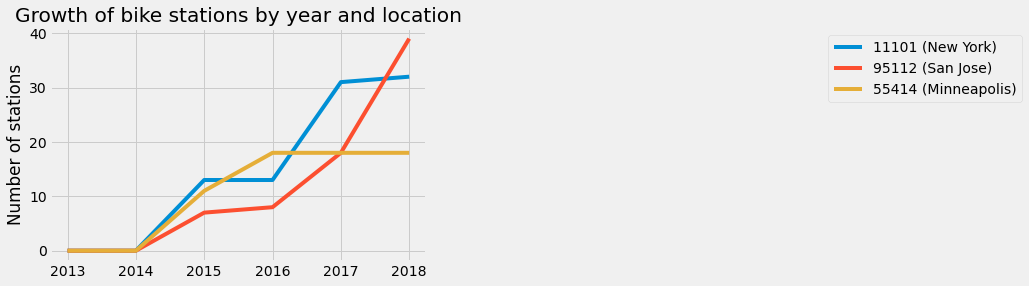

In [61]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

examples = bikes_features[['zip','City','year','bs_total_stations']].drop_duplicates()
examples['year_added'] = examples['year'].astype(int)-1

for z in ['11101','95112','55414']:
    temp = examples.loc[examples['zip']==z,:]
    x = temp['year_added']   
    y = temp['bs_total_stations'].astype('int')
    # plot line
    plt.plot(x, y, label = f"{z} ({temp['City'].unique()[0]})")
plt.legend(bbox_to_anchor=(2.05, 1.0), loc='upper left')
#plt.tight_layout()
plt.ylabel('Number of stations')
plt.title('Growth of bike stations by year and location')

plt.savefig('Bikestations.png',dpi=300,bbox_inches='tight')

plt.show() 

In [191]:
df['year'].max()

2018

In [197]:
d = df[df['year']==2018].groupby('city').agg({'fac_id':'count'}).reset_index().sort_values(by='fac_id',ascending=False).head(20)

In [205]:
d = d.sort_values(by='fac_id',ascending=True)

Text(0.5, 1.0, 'Top 20 Cities with Bike Sharing Systems')

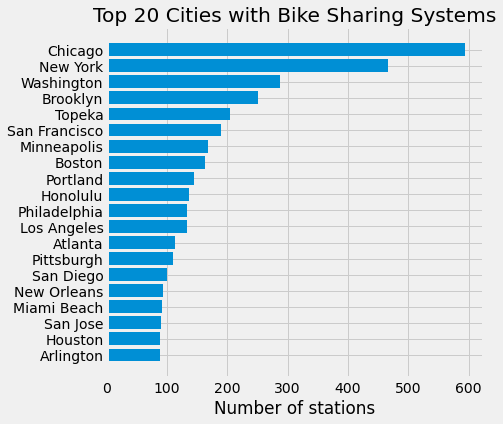

In [207]:
plt.barh(y=d['city'],width=d['fac_id'])
#plt.ylabel('Top 20 cities')
plt.xlabel('Number of stations')
plt.title('Top 20 Cities with Bike Sharing Systems')


In [187]:
d

,city,fac_id


In [160]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
dates = viz['year_added']
stations = [3,3,3,3,3]
  
# plot lines
plt.plot(x, y, label = "line 1")
plt.plot(y, x, label = "line 2")
plt.plot(x, np.sin(x), label = "curve 1")
plt.plot(x, np.cos(x), label = "curve 2")


plt.show()

KeyError: 'year_added'